## 案1　グレースケールに変換する前に、減色しておく

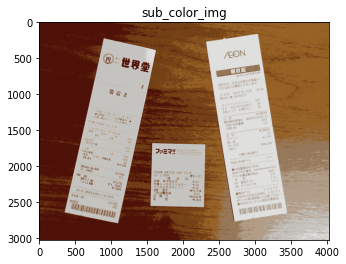

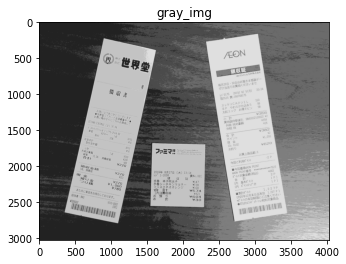

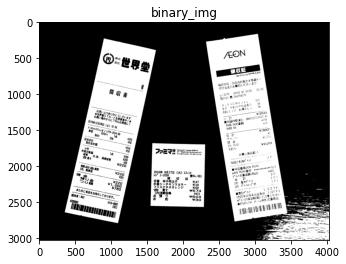

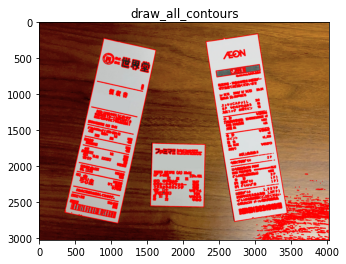

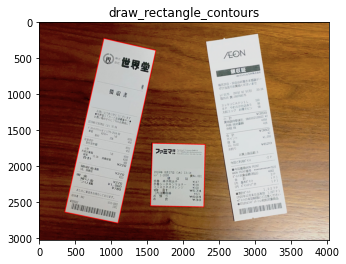

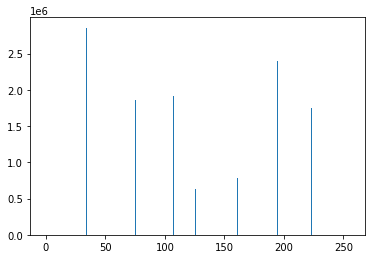

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def sub_color(img, K):
    """色数を指定して減色する
    """
    pixels = img.reshape(-1, 3).astype(np.float32)
    criteria = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centers = cv2.kmeans(pixels, K, None, criteria, attempts, flags)
    sub_color_img = centers[labels].reshape(img.shape).astype(np.uint8)
    plot_img(sub_color_img, 'sub_color_img')
    return sub_color_img


def plot_histgram(img):
    """画像の画素値の分布をヒストグラムにする
    """
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    plt.bar([i for i in range(0,256)], hist.ravel())
    plt.show()


def binarize(img):
    """画像を2値化する
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plot_img(gray_img, 'gray_img')
    threshold = np.unique(np.array(gray_img).ravel())[-2] -1  # 白側から2色と3色の間の位置を閾値とする
    _, binary_img = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY)
    plot_img(binary_img, 'binary_img')
    return gray_img, binary_img


def find_contours(img):
    """輪郭の一覧を得る
    """
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def approximate_contours(img, contours):
    """輪郭を条件で絞り込んで矩形のみにする
    """
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if arclen != 0 and img_size*0.02 < area < img_size*0.9:
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.01*arclen, closed=True)
            if len(approx_contour) == 4:
                approx_contours.append(approx_contour)
    return approx_contours


def draw_contours(img, contours, file_name):
    """輪郭を画像に書き込む
    """
    draw_contours_file = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 10)
    plot_img(draw_contours_file, file_name)


def plot_img(img, file_name):
    """画像の書き出し
    """
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(file_name)
    plt.show()
    cv2.imwrite('./{}.png'.format(file_name), img)


def get_receipt_contours(img, K):
    """矩形検出までの一連の処理を引数の色数で行う
    """
    sub_color_img = sub_color(img, K)
    gray_img, binary_img = binarize(sub_color_img)
    contours = find_contours(binary_img)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, contours, 'draw_all_contours')
    draw_contours(img, approx_contours, 'draw_rectangle_contours')
    plot_histgram(gray_img)


# 7色に減色して矩形検出を試す
input_file = cv2.imread('../img/unprocessed/IMG_7455.jpg')
get_receipt_contours(input_file, 7)

## 案2　HSV空間で白の範囲を指定する

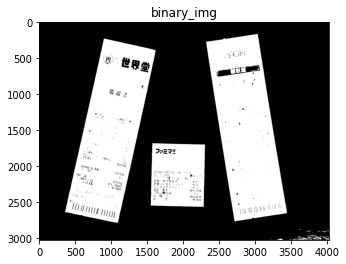

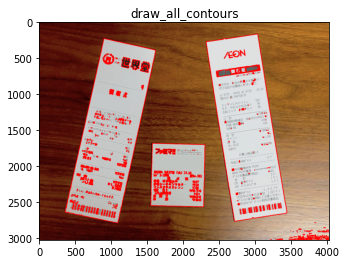

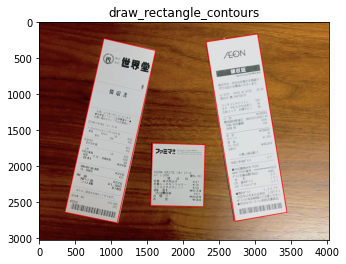

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def binarize(img):
    """画像を2値化する
    """
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_white = np.array([0,0,100])  # 白色とみなすHSVの各値の下限
    upper_white = np.array([180,25,255])  # 白色とみなすHSVの各値の上限
    binary_img = cv2.inRange(hsv_img, lower_white, upper_white)
    plot_img(binary_img, 'binary_img')
    return binary_img


def find_contours(img):
    """輪郭の一覧を得る
    """
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def approximate_contours(img, contours):
    """輪郭を条件で絞り込んで矩形のみにする
    """
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if arclen != 0 and img_size*0.02 < area < img_size*0.9:
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.01*arclen, closed=True)
            if len(approx_contour) == 4:
                approx_contours.append(approx_contour)
    return approx_contours


def draw_contours(img, contours, file_name):
    """輪郭を画像に書き込む
    """
    draw_contours_file = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 10)
    plot_img(draw_contours_file, file_name)


def plot_img(img, file_name):
    """画像の書き出し
    """
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(file_name)
    plt.show()
    cv2.imwrite('./{}.png'.format(file_name), img)


def get_receipt_contours(img):
    """矩形検出までの一連の処理を行う
    """
    binary_img = binarize(img)
    contours = find_contours(binary_img)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, contours, 'draw_all_contours')
    draw_contours(img, approx_contours, 'draw_rectangle_contours')


input_file = cv2.imread('../img/unprocessed/IMG_7455.jpg')
get_receipt_contours(input_file)

## 案3　エッジ検出

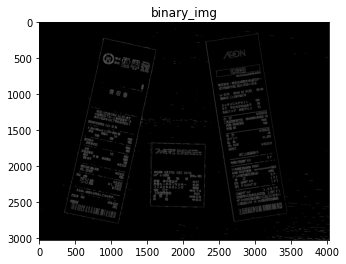

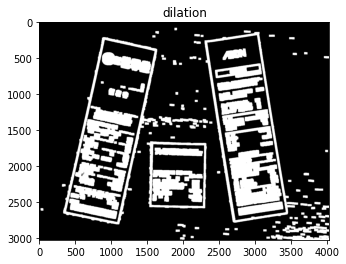

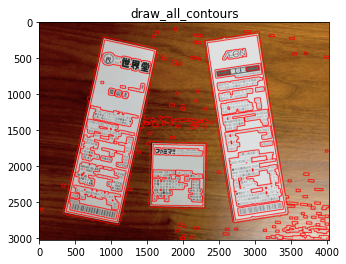

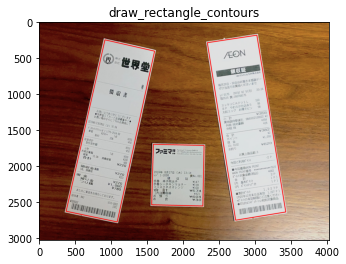

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def binarize(img):
    """画像を2値化する
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_img = cv2.Canny(gray_img, 100, 200)
    plot_img(binary_img, 'binary_img')
    binary_img = binary_img.astype('uint8')
    return binary_img


def noise_reduction(img):
    """ノイズ処理(膨張)を行う
    """
    kernel = np.ones((30,30), np.uint8)
    dilation = cv2.dilate(img, kernel, iterations=1)
    plot_img(dilation, 'dilation')
    return dilation


def find_contours(img):
    """輪郭の一覧を得る
    """
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def approximate_contours(img, contours):
    """輪郭を条件で絞り込んで矩形のみにする
    """
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if arclen != 0 and img_size*0.02 < area < img_size*0.9:
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.01*arclen, closed=True)
            if len(approx_contour) == 4:
                approx_contours.append(approx_contour)
    return approx_contours


def draw_contours(img, contours, file_name):
    """輪郭を画像に書き込む
    """
    draw_contours_file = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 10)
    plot_img(draw_contours_file, file_name)


def plot_img(img, file_name):
    """画像の書き出し
    """
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(file_name)
    plt.show()
    cv2.imwrite('./{}.png'.format(file_name), img)


def get_receipt_contours(img):
    """矩形検出までの一連の処理を行う
    """
    binary_img = binarize(img)
    noise_reduction_binary_img = noise_reduction(binary_img)
    contours = find_contours(noise_reduction_binary_img)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, contours, 'draw_all_contours')
    draw_contours(img, approx_contours, 'draw_rectangle_contours')


input_file = cv2.imread('../img/unprocessed/IMG_7455.jpg')
get_receipt_contours(input_file)

## 案4 適応的しきい値処理

adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst])

- adaptiveMethod：小領域中でのしきい値の計算方法
  - cv2.ADAPTIVE_THRESH_MEAN_C : 近傍領域の中央値をしきい値とする
  - cv2.ADAPTIVE_THRESH_GAUSSIAN_C : 近傍領域の重み付け平均値をしきい値とする　重みの値はGaussian分布になるように計算
- Block Size： しきい値計算に使用する近傍領域のサイズ（奇数とする）
- C： 計算されたしきい値から引く定数

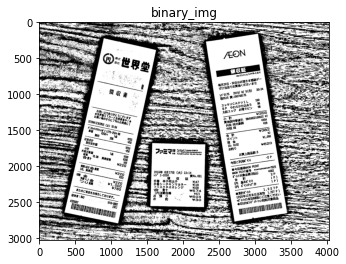

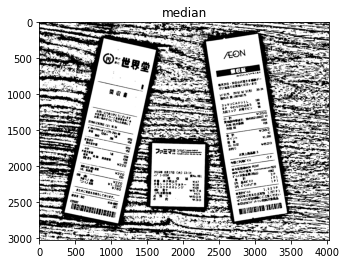

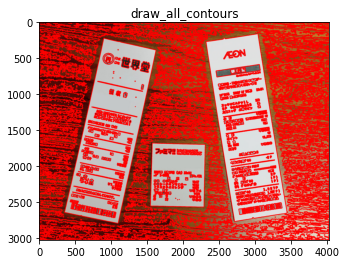

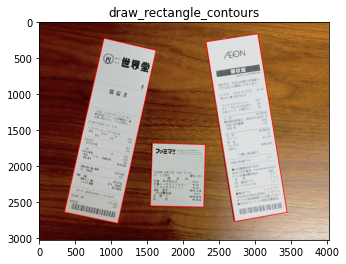

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def binarize(img):
    """画像を2値化する
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 2)
    plot_img(binary_img, 'binary_img')
    return binary_img


def noise_reduction(img):
    """ノイズ処理(中央値フィルタ)を行う
    """
    median = cv2.medianBlur(img, 9)
    plot_img(median, 'median')
    return median


def find_contours(img):
    """輪郭の一覧を得る
    """
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def approximate_contours(img, contours):
    """輪郭を条件で絞り込んで矩形のみにする
    """
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if arclen != 0 and img_size*0.02 < area < img_size*0.9:
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.05*arclen, closed=True)
            if len(approx_contour) == 4:
                approx_contours.append(approx_contour)
    return approx_contours


def draw_contours(img, contours, file_name):
    """輪郭を画像に書き込む
    """
    draw_contours_file = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 10)
    plot_img(draw_contours_file, file_name)


def plot_img(img, file_name):
    """画像の書き出し
    """
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(file_name)
    plt.show()
    cv2.imwrite('./{}.png'.format(file_name), img)


def get_receipt_contours(img):
    """矩形検出までの一連の処理を行う
    """
    binary_img = binarize(img)
    binary_img = noise_reduction(binary_img)
    contours = find_contours(binary_img)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, contours, 'draw_all_contours')
    draw_contours(img, approx_contours, 'draw_rectangle_contours')


input_file = cv2.imread('../img/unprocessed/IMG_7455.jpg')
get_receipt_contours(input_file)